# Chapter: 14
## Section: Generative modeling using PyTorch

In [ ]:
!pip install torch
!pip install torchvision

In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
torch.manual_seed(10)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Defining encoding layers
        self.encoder = nn.Sequential(
            nn.Linear(32 * 32 * 3, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
        )

        # Defining two linear (fully connected) layers for mean and
        # log varaince of the latent variable space which can be used
        # later to generate new data
        self.fc_mean = nn.Linear(128, 32)
        self.fc_var = nn.Linear(128, 32)

        # Definign decoding layers
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 32 * 32 * 3),
            nn.Sigmoid(),
        )

    def forward(self, x):
        h = self.encoder(x.view(-1, 32 * 32 * 3))
        mean, logvar = self.fc_mean(h), self.fc_var(h)

        std = torch.exp(0.5*logvar)
        q = torch.distributions.Normal(mean, std)
        z = q.rsample()

        return self.decoder(z), mean, logvar

In [3]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=2e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 32 * 32 * 3), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [4]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_dataset = datasets.Flowers102(root='./data', download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


100%|██████████| 344862509/344862509 [00:11<00:00, 30269509.40it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 466343.43it/s]


100%|██████████| 14989/14989 [00:00<00:00, 8195596.75it/s]


In [5]:
n_epoch = 400

for epoch in range(n_epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mean, logvar = model(data)
        loss = loss_function(recon_batch, data, mean, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch: 0 Average loss: 1958.8619
Epoch: 1 Average loss: 1900.0250
Epoch: 2 Average loss: 1889.3991
Epoch: 3 Average loss: 1874.4706
Epoch: 4 Average loss: 1859.7581
Epoch: 5 Average loss: 1855.7497
Epoch: 6 Average loss: 1850.3360
Epoch: 7 Average loss: 1845.3444
Epoch: 8 Average loss: 1837.6384
Epoch: 9 Average loss: 1832.0185
Epoch: 10 Average loss: 1826.9738
Epoch: 11 Average loss: 1824.7848
Epoch: 12 Average loss: 1818.7076
Epoch: 13 Average loss: 1814.4209
Epoch: 14 Average loss: 1811.6238
Epoch: 15 Average loss: 1809.1074
Epoch: 16 Average loss: 1808.7485
Epoch: 17 Average loss: 1804.1237
Epoch: 18 Average loss: 1798.9417
Epoch: 19 Average loss: 1796.9909
Epoch: 20 Average loss: 1793.7974
Epoch: 21 Average loss: 1792.4214
Epoch: 22 Average loss: 1789.4588
Epoch: 23 Average loss: 1787.9213
Epoch: 24 Average loss: 1787.4937
Epoch: 25 Average loss: 1784.8701
Epoch: 26 Average loss: 1783.6686
Epoch: 27 Average loss: 1783.3177
Epoch: 28 Average loss: 1782.2267
Epoch: 29 Average loss: 

In [6]:
# model.eval()
# with torch.no_grad():
#     sample = torch.randn(4, 32).to(device)
#     sample = model.decoder(sample).cpu()

# grid = make_grid(sample.view(4, 3, 32, 32))
# plt.imshow(grid.permute(1, 2, 0))
# plt.show()

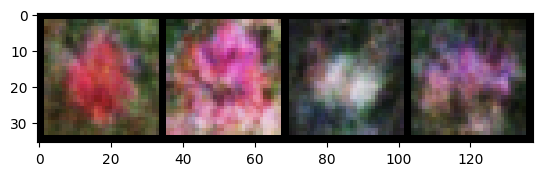

In [7]:
model.eval()
with torch.no_grad():
    sample = torch.randn(4, 32).to(device)
    sample = model.decoder(sample).cpu()

grid = make_grid(sample.view(4, 3, 32, 32))
plt.imshow(grid.permute(1, 2, 0))
plt.show()